## Importing libraries and dataset

In [77]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc


from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [43]:
# Download dataset from Kaggle
os.system("kaggle datasets download -d uciml/adult-census-income")
os.system("unzip adult-census-income.zip -d data")


Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income
License(s): CC0-1.0
adult-census-income.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  adult-census-income.zip


replace data/adult.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


256

In [44]:
df = pd.read_csv('data/adult.csv')

### Highlights
- Libraries: Importing libraries for data manipulation, visualization, machine learning and handing imbalanced datasets.

- Dataset Download: Using the Kaggle API to download the Adult Income dataset and unzip it.

- Loading: 'dd.read_csv' to load the csv into a dask dataframe

## Load and Clean the data
- Cleaning: Stripping whitespace from column names and the target variable. Dropping rows with null values

In [45]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [46]:
df.shape

(32561, 15)

In [47]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [51]:
# Initial cleaning and filtering of the dataset
df = df.dropna()

df = df.rename(columns=lambda x:x.strip())
df['income'] = df['income'].str.strip()

In [52]:
df.shape

(32561, 15)

As we notice by printing df.shape, no rows were dropped during dropna. We are working with a seemingly clean dataset.

### Data Visualization

/var/folders/mw/mxt1b_qn1x1_3l322qvcsx_00000gn/T/ipykernel_19883/416923543.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_sample.corr(), annot=True, cmap='coolwarm')


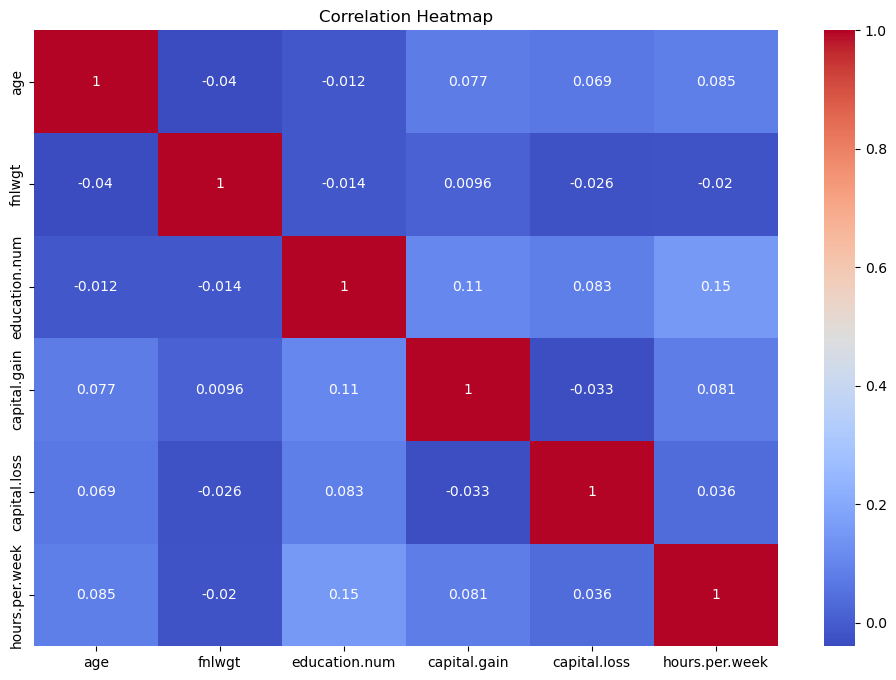

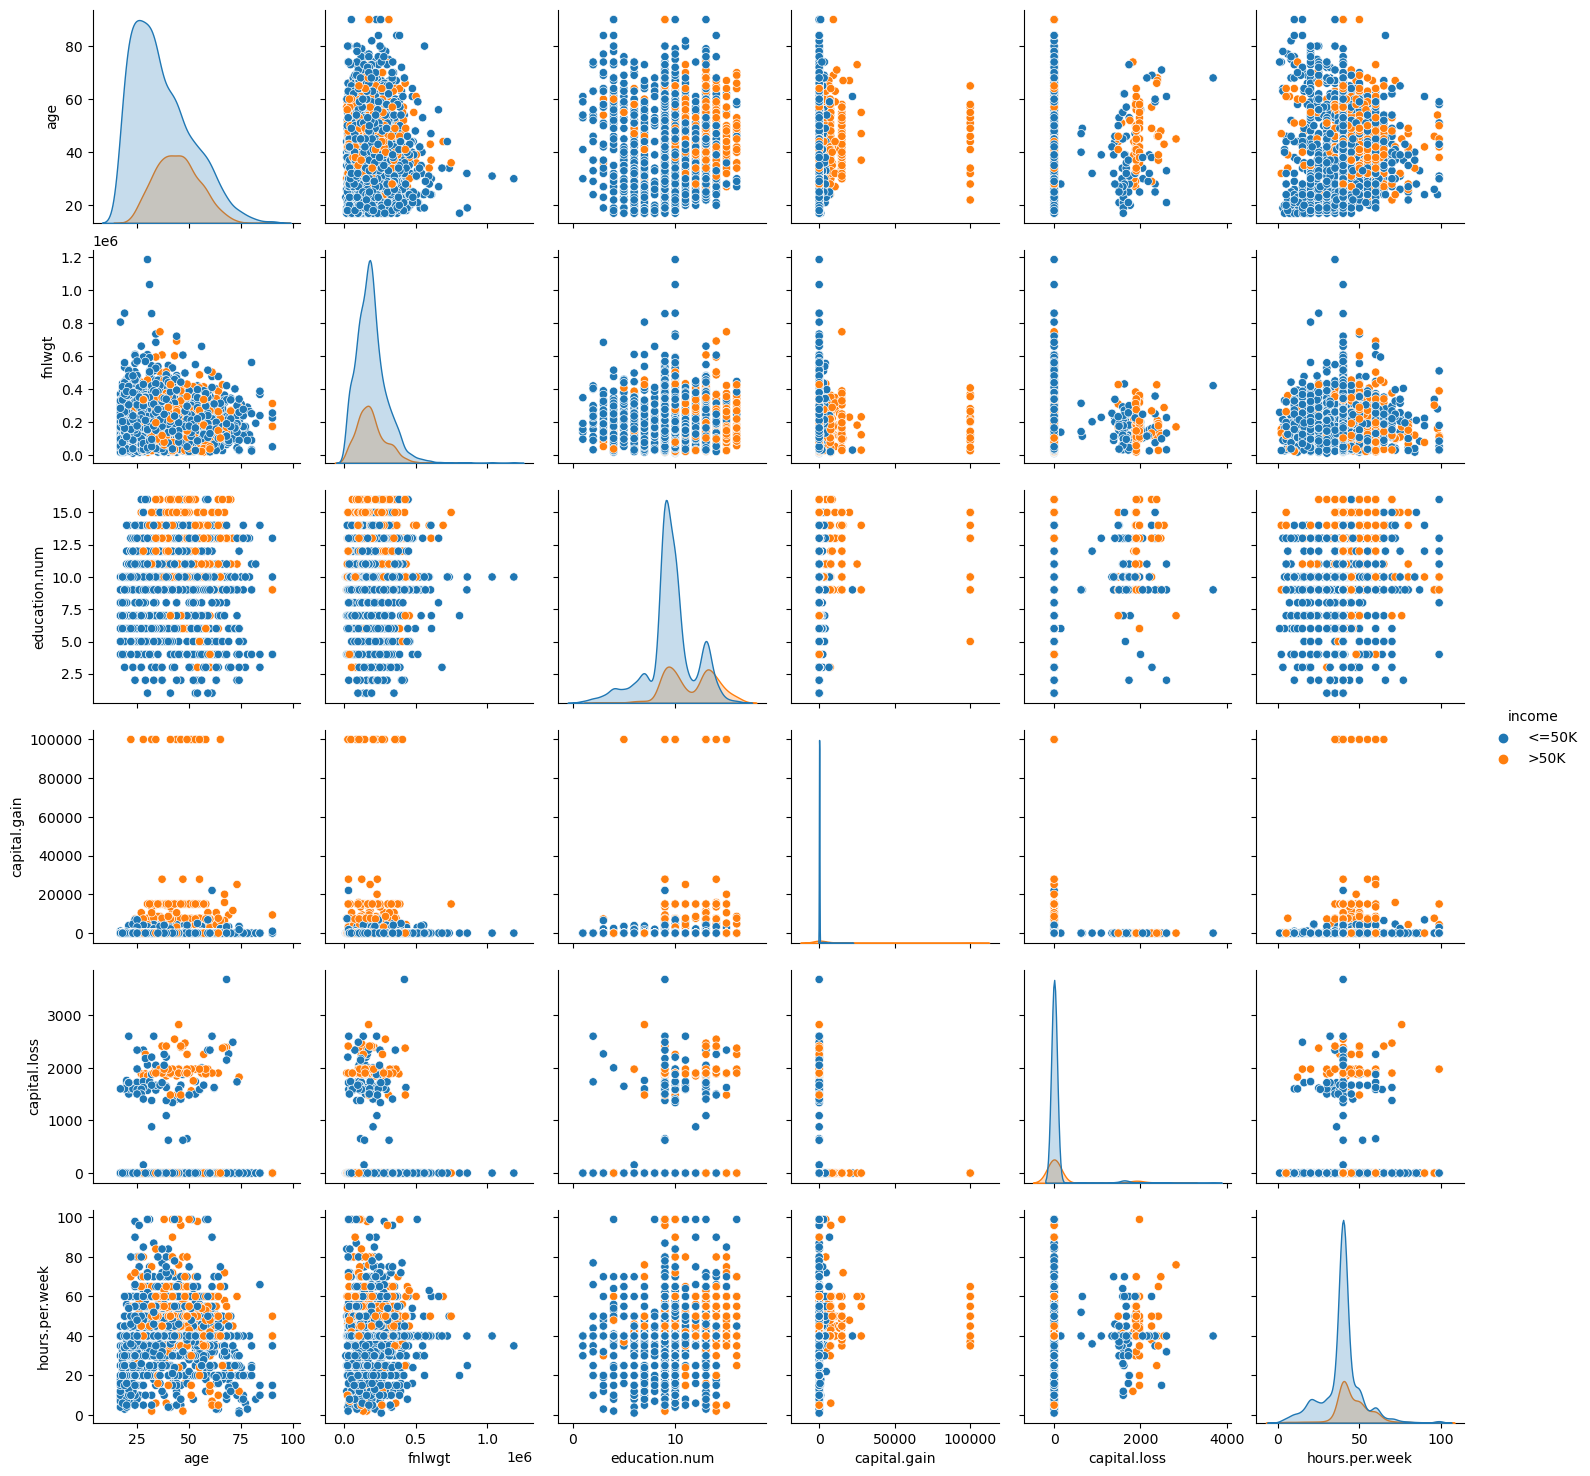

/Users/amol/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


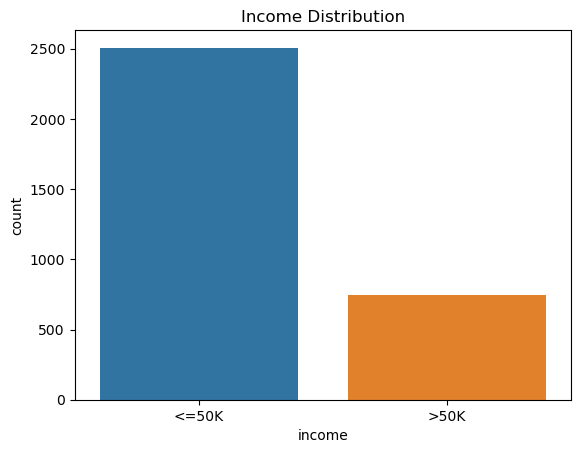

In [54]:
# Generating visualizations to better understand the data

df_sample = df.sample(frac=0.1)

# Correlation heatmap

plt.figure(figsize = (12,8))
sns.heatmap(df_sample.corr(), annot=True, cmap='coolwarm')


plt.title('Correlation Heatmap')
plt.show()


# Pairplot
sns.pairplot(df_sample, hue='income')
plt.show()

# Distribution of target variable
sns.countplot(df_sample['income'])
plt.title('Income Distribution')
plt.show()

## More visualizations to understand the relationships between variables

### Income Distribution by Gender

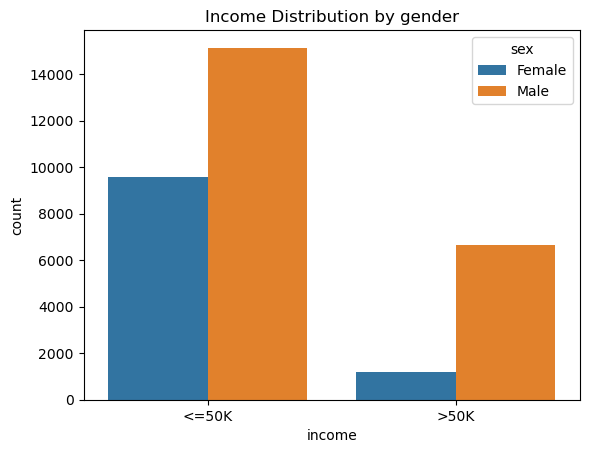

In [72]:
sns.countplot(x='income', hue='sex', data=df)
plt.title('Income Distribution by gender')
plt.show()

### Age vs Income

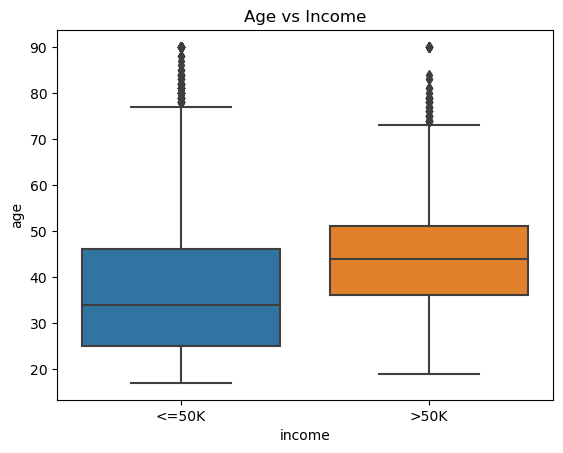

Insight: Shows how age impacts income, with higher age groups tending to have higher income until a certain age.


In [75]:
sns.boxplot(x='income', y = 'age', data = df)
plt.title('Age vs Income')
plt.show()
print("Insight: Shows how age impacts income, with higher age groups tending to have higher income until a certain age.")

Text(0.5, 1.0, 'Age vs Income')

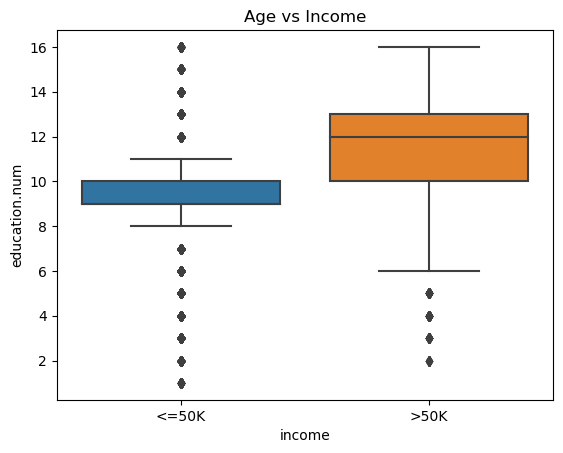

In [76]:
sns.boxplot(x='income', y = 'education.num', data = df)
plt.title('Age vs Income')

## Define Features and Target


In [55]:
X = df.drop('income', axis = 1)
y = df['income']

## Handle imbalanced data using SMOTE

SMOTE - Synthetic Minority Over-sampling Technique - is a popular technique for addressing the issue of class imbalance in datasets. It is often used in the context of binary classification problems where one class (the minority class) is underrepresented. 
It works by generating synthetic samples for the minority class rather than simply duplicating existing minority instances. It does this by creating new samples along the line segments joining existing minority class samples.

#### Advantages:
- Improved performance: By balancing the distribution, the model often performs bettter as they are not biased towards the majority class

- Synthetic generation: Unlike random oversampling, SMOTE generates new, realistic instances of the minority class, which can help the model generalize better

- Combats overfitting: It reduces the risk of overfitting compared to simply duplicating the minority class samples

#### Disadvantages:
- Noise Introduction: SMOTE might create samples that might skew the actual distribution of data

- Overlapping classes: It might cause synthetic samples to overlap with the majority class, leading to class ambiguity

- Computational Complexity: Generating synthetic samples might need computing resources, especially when working with large datasets

### Implementing SMOTE: 
- We use the imblearn library, which is a part of scikit-learn-contrib 

In [56]:
smote = SMOTE(random_state=42)

## Define Preprocessing Steps


In [58]:
# Let's take a look at the data types of the different columns 

df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

### StandardScaler() and OneHotEncoder()
- StandardScaler(): This technique centers the data by subtracting the mean value of each feature. As a result, the mean of the feature becomes zero

- One Hot Encoding: This converts variables into a series of binary columns, each representing a single category from the original data. It could also be described as creating dummy variables.

In [59]:
# Set up preprocessing for numeric and categorical variables
numeric_features = X.select_dtypes(include=['int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

## Define and Create the Model Pipeline

- Here we choose RandomForestClassifier for it's robustness against overfitting, handling of imbalanced data, among other features

In [60]:
# Define the model

model = RandomForestClassifier(random_state = 39)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', model)
])

## Split the data into Train and Test sets

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

# Hyperparameter tuning

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2,5],
}


grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)


print("Best parameters", grid_search.best_params_)

Best parameters {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


## Make predictions and evaluate the model


In [64]:

y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Accuracy", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy 0.8530631045601106
Confusion Matrix:
 [[4444  544]
 [ 413 1112]]
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4988
        >50K       0.67      0.73      0.70      1525

    accuracy                           0.85      6513
   macro avg       0.79      0.81      0.80      6513
weighted avg       0.86      0.85      0.86      6513

